<a href="https://colab.research.google.com/github/Benj-admin/MAP583_X/blob/main/TP/TP05_predictions_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Engine Failure with RNN

In this practicals, the goal is to predict the failure of an engine. The training dataset is made of time series obtained from several sensors on the engine until failure. The test dataset is made of the start of these time series and a failure date.

We will build a simple RNN taking as input the multi-dimensional time serie characterizing the engine and learn its parameters to predict the time of failure at each instant. At the start, the best prediction without any input data should be the average of the failure times in the dataset and as more and more data is fed in the RNN, it should give a better and better estimate.

The dataset is provided by [NASA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), see also [Kaggle](https://www.kaggle.com/datasets/suriyachayatummagoon/cmapssdata?select=Damage+Propagation+Modeling.pdf)

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
torch.__version__

'2.8.0+cu126'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


## 1. Downloading the data

This need to be done only once!

You can find the data on the website of the [NASA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) or on [Kaggle](https://www.kaggle.com/datasets/suriyachayatummagoon/cmapssdata?select=Damage+Propagation+Modeling.pdf) or on my website:

In [4]:
%mkdir data
%cd data

/content/data


In [5]:
!wget 'https://www.di.ens.fr/~lelarge/CMAPSSData.zip'

--2025-10-23 10:30:34--  https://www.di.ens.fr/~lelarge/CMAPSSData.zip
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘CMAPSSData.zip’

CMAPSSData.zip          [               <=>  ]  11.85M  1.28MB/s    in 18s     

2025-10-23 10:30:53 (677 KB/s) - ‘CMAPSSData.zip’ saved [12425978]



In [6]:
!unzip CMAPSSData.zip

Archive:  CMAPSSData.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt           
  inflating: RUL_FD004.txt           
  inflating: test_FD001.txt          
  inflating: test_FD002.txt          
  inflating: test_FD003.txt          
  inflating: test_FD004.txt          
  inflating: train_FD001.txt         
  inflating: train_FD002.txt         
  inflating: train_FD003.txt         
  inflating: train_FD004.txt         


In [7]:
%cd ..

/content


## 2. Loading the data

In [8]:
def get_CMAPSSData(nb_file):
    # get data from file and pre process it (normalization and convert to pandas)
    dataset_train = pd.read_csv('./data/train_FD00{}.txt'.format(nb_file),
                                sep=' ', header=None).drop([26, 27], axis=1)
    dataset_test = pd.read_csv('./data/test_FD00{}.txt'.format(nb_file),
                               sep=' ', header=None).drop([26, 27], axis=1)
    test_truth = pd.read_csv('./data/RUL_FD00{}.txt'.format(nb_file),
                             sep=' ', header=None).drop([1], axis=1)
    col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                 's9',
                 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
    dataset_train.columns = col_names
    dataset_test.columns = col_names
    test_truth.columns = ['more']
    test_truth['id'] = test_truth.index + 1
    rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    test_truth['rtf'] = test_truth['more'] + rul['max']
    test_truth.drop('more', axis=1, inplace=True)
    dataset_test = dataset_test.merge(test_truth, on=['id'], how='left')
    dataset_test['ttf'] = dataset_test['rtf'] - dataset_test['cycle']
    dataset_test.drop('rtf', axis=1, inplace=True)
    dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max) - dataset_train['cycle']
    features_col_name = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                         's9', 's10', 's11',
                         's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
    target_col_name = 'ttf'
    relevant_features_col_name = []
    for col in features_col_name:
        if not (len(dataset_train[col].unique()) == 1):
            relevant_features_col_name.append(col)
    sc = MinMaxScaler()
    dataset_train[features_col_name] = sc.fit_transform(dataset_train[features_col_name])
    dataset_test[features_col_name] = sc.transform(dataset_test[features_col_name])
    return dataset_train, dataset_test, relevant_features_col_name, target_col_name


def to_lists_of_tensors(dataset, features_col_name, target_col_name):
    # take pandas df and convert it to list of tensors (for pytorch)
    X, y = [], []
    nb_sequences = max(dataset['id'])
    for i in range(1, nb_sequences + 1):
        df_zeros = dataset.loc[dataset['id'] == i]
        df_one_x = df_zeros[features_col_name]
        df_one_y = df_zeros[target_col_name]
        X.append(torch.from_numpy(np.expand_dims(df_one_x.values, 1)).type(torch.FloatTensor))
        y.append(torch.from_numpy(df_one_y.values).type(torch.FloatTensor))
    return X, y


def convert_train_and_test_to_appropriate_format(dataset_train, dataset_test, features_col_name, target_col_name):
    # take 2 datasets (train and test and covert them to lists of tensors)
    X_train, y_train = to_lists_of_tensors(dataset_train, features_col_name, target_col_name)
    X_test, y_test = to_lists_of_tensors(dataset_test, features_col_name, target_col_name)
    return X_train, y_train, X_test, y_test


In [9]:
%pycat ./data/readme.txt

In [10]:
dataset_train, dataset_test, features_col_name, target_col_name = get_CMAPSSData(1)
X_train, y_train, X_test, y_test = convert_train_and_test_to_appropriate_format(dataset_train, dataset_test,
                                                                                    features_col_name, target_col_name)

/tmp/ipython-input-2139691400.py:23: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max) - dataset_train['cycle']


In [11]:
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187


Here I have done the minimal preprocessing of the data using the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) of sklearn to scale each feature in (0,1).

`X_train` is a list where each element is of shape (length_of_sequence,1,number_of_sensors) where the second dimension with value 1 corresponds to the batch size. As in the course, we will not proceed sequences by batches but one after the other.

In [12]:
X_train[0].shape

torch.Size([192, 1, 17])

## 3. WTTE-RNN model

Here, we follow an approach inspired from this [blog](https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/#wtte-rnn-produces-risk-embeddings).

You first need to define a GRU (or LSTM) that will take as input a sequence of shape (length_of_sequence,1,number_of_sensors) and output a sequence of shape (length_of_sequence,2) obtained by passing the output of the GRU through a linear layer. As we want positive number, you will take the exponent.

In [85]:
class GRUnet(nn.Module):
    def __init__(self, dim_input, num_layers, dim_hidden, dim_output=2):
        super(GRUnet, self).__init__()

        # --- Useful Constants ---

        self.num_layers = num_layers
        self.hidden_dim = dim_hidden
        self.dim_input = dim_input
        self.dim_output = dim_output

        # --- Manual GRU Cell Implementation ---

        # 1. Layers for the CANDIDATE HIDDEN STATE (h_tilde)
        self.fc_x2h = nn.Linear(dim_input, dim_hidden)
        self.fc_h2h = nn.Linear(dim_hidden, dim_hidden, bias = False)

        # 2. Layers for the RESET GATE (R)
        self.fc_x2r = nn.Linear(dim_input, dim_hidden)
        self.fc_h2r = nn.Linear(dim_hidden, dim_hidden, bias = False)

        # 3. Layers for the UPDATE GATE (Z)
        self.fc_x2z = nn.Linear(dim_input, dim_hidden)
        self.fc_h2z = nn.Linear(dim_hidden, dim_hidden, bias = False)

        # 4. Final Output Layer (or Prediction Layer)
        self.fc_h2y = nn.Linear(dim_hidden,dim_output)


    def forward(self, x):
        # Initialize the hidden state (h0), and the output_list.
        h = x.new_zeros(1, self.hidden_dim)
        out =  []

        # Loop over the time sequence
        for t in range(x.size(0)):
            # 1. Compute the Reset Gate (r)
            r = torch.sigmoid(self.fc_x2r(x[t,:])+self.fc_h2r(h))

            # 2. Compute the Candidate Hidden State
            hb = torch.tanh(self.fc_x2h(x[t,:])+self.fc_h2h(r*h))

            # 3. Compute the Update Gate (z)
            z = torch.sigmoid(self.fc_x2z(x[t,:])+self.fc_h2z(h))

            #4. Update the Hidden State (h(t))
            h = z*hb + (1-z)*h

            #5. Store the output at this time in the list (y(t))
            out.append(torch.exp(self.fc_h2y(h)))

        # --- Sortie Finale ---

        return torch.stack(out, dim=0)


Test your network

In [86]:
model = GRUnet(dim_input=len(features_col_name), num_layers=3, dim_hidden=50)
model = model.to(device)

In [87]:
output = model(X_train[0].to(device))

In [88]:
output.shape

torch.Size([192, 1, 2])

In order to learn the parameters of your RNN, you need to specify a loss and we will here follow a standard approach in reliability theory: we model the failure time as a [Weibull random variable](http://reliawiki.org/index.php/The_Weibull_Distribution)

$$
\mathbb{P}(X>t) = \exp(- \left(\frac{t}{\eta}\right)^{\beta}),
$$
where $\eta$ is the scale parameter and $\beta$ is the shape parameter.

Note that we have for the mean of a Weibull distribution:
$$
\mathbb{E}[X] = \eta \Gamma(1+1/\beta),
$$
where $\Gamma$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function).

In our case, we will interpret the 2 outputs of the RNN as estimates for the parameters $\eta$ and $\beta$. In order to design a loss, we compute the log-likelihood:
\begin{eqnarray*}
\log f(t) &=& \log\left( \frac{\beta}{\eta}\right) +(\beta -1)\log\left(\frac{t}{\eta}\right) -\left(\frac{t}
{\eta} \right)^{\beta}\\
&=& \log \beta +\beta \log\left(\frac{t}{\eta}\right) -\log t-\left(\frac{t}
{\eta} \right)^{\beta}
\end{eqnarray*}

Define a loss function corresponding to the negative log-likelihood (add a small parameter $\epsilon$ to $t$ in order not to compute $\log 0$).

In [98]:
class weibull_loss(nn.Module):
    def __init__(self):
        super(weibull_loss, self).__init__()
        self.epsilon = 1e-6

    def forward(self, output, y):
        output_t = output.squeeze(dim = 1)
        eta, beta = output[:,0],output[:,1]
        loss_per_step = -(torch.log(beta/eta) + (beta-1)*torch.log((y+self.epsilon)/eta) - ((y+self.epsilon)/eta)**(beta))
        return torch.mean(loss_per_step)



Test your loss function.

In [99]:
loss_fn = weibull_loss()
loss_fn(output.squeeze(),y_train[0].to(device))

tensor(55.8238, grad_fn=<MeanBackward0>)

## 4. Training your model

Code your taining and testing loops.

You might want to use a scheduler like `torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1, verbose='True',threshold=0.001)`

In [100]:
def train_epoch(X_train, y_train, model, loss_fn, optimizer, device):
    # train the model through the whole training dataset for one epoch
    # return the corresponding loss on the epoch
    model.to(device)
    model.train()

    running_loss = 0.

    n_samples = len(X_train)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X_train = [X_train[i] for i in indices]
    y_train = [y_train[i] for i in indices]

    for inputs, targets in zip(X_train, y_train):
        ## Load the inputs to device, and apply the pre-processing function
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    n_train = len(X_train)

    return running_loss/n_train


def test_epoch(X_test, y_test, model, loss_fn, device):
    # evaluate the model through the whole testing dataset
    # return the corresponding loss
    model.to(device)
    model.eval()

    running_loss = 0.

    for inputs, targets in zip(X_test, y_test):
        ## Load the inputs to device, and apply the pre-processing function
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), targets)
        running_loss += loss.item()

    n_test = len(X_test)
    return running_loss/n_test


def fit(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, nb_epochs, device):
    # fit the model by training it nb_epochs times
    train_loss_t, test_loss_t = [], []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=1,threshold=0.001)

    for epoch in range(nb_epochs):
        train_loss = train_epoch(X_train, y_train, model, loss_fn, optimizer, device)
        train_loss_t.append(train_loss)
        test_loss = test_epoch(X_test, y_test, model, loss_fn, device)
        test_loss_t.append(test_loss)
        print(f"[TRAIN epoch{epoch+1}/{nb_epochs}] Train Loss: {train_loss:.5f} Test Loss: {test_loss:.5f}")
        scheduler.step(test_loss)
    return model, train_loss_t, test_loss_t



In [101]:
model = GRUnet(dim_input=len(features_col_name), num_layers=3, dim_hidden=50,dim_output=2)
model = model.to(device)

In [102]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = weibull_loss()
nb_epochs = 50

In [103]:
model, train_loss_t, test_loss_t = fit(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, nb_epochs,device)

[TRAIN epoch0/50] Train Loss: 10.20434 Test Loss: 7.18917%
[TRAIN epoch1/50] Train Loss: 5.75676 Test Loss: 5.78860%
[TRAIN epoch2/50] Train Loss: 5.53644 Test Loss: 5.69212%
[TRAIN epoch3/50] Train Loss: 5.42346 Test Loss: 5.68465%
[TRAIN epoch4/50] Train Loss: 5.37716 Test Loss: 6.52555%
[TRAIN epoch5/50] Train Loss: 5.51026 Test Loss: 5.55097%
[TRAIN epoch6/50] Train Loss: 5.24671 Test Loss: 5.51243%
[TRAIN epoch7/50] Train Loss: 5.15837 Test Loss: 5.22614%
[TRAIN epoch8/50] Train Loss: 5.09958 Test Loss: 5.71185%
[TRAIN epoch9/50] Train Loss: 5.53483 Test Loss: 6.27745%
[TRAIN epoch10/50] Train Loss: 5.15407 Test Loss: 5.25737%
[TRAIN epoch11/50] Train Loss: 4.85174 Test Loss: 5.13402%
[TRAIN epoch12/50] Train Loss: 4.93189 Test Loss: 5.23576%
[TRAIN epoch13/50] Train Loss: 4.91397 Test Loss: 5.51221%
[TRAIN epoch14/50] Train Loss: 4.77465 Test Loss: 5.09850%
[TRAIN epoch15/50] Train Loss: 4.70505 Test Loss: 5.18908%
[TRAIN epoch16/50] Train Loss: 4.78543 Test Loss: 5.09067%
[TRAIN

In [104]:
def plot_losses(train_loss_t, test_loss_t):
    nb_epochs = len(train_loss_t)
    plt.plot(range(nb_epochs), train_loss_t, color='orange', label='Loss on the training set')
    plt.plot(range(nb_epochs), test_loss_t, color='green', label='Loss on the testing set')
    plt.legend()
    plt.show()

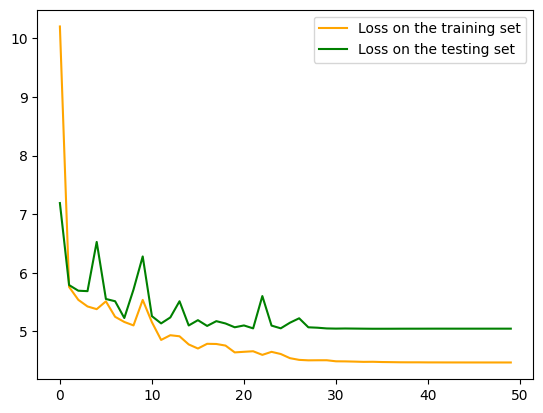

In [105]:
plot_losses(train_loss_t, test_loss_t)

## 5. Looking at your results

To compute a baseline, I am computing the average of all failure times in the train dataset.

In [106]:
max_val = np.zeros(len(y_train))
for i,y in enumerate(y_train):
    max_val[i] = y[0].item()
baseline = np.mean(max_val)

Here I am computing all the predictions made by my model on the test set and exporting these into `numpy`.

In [115]:
def compute_np(model,X_test, y_test,baseline=baseline,device=device,max_size=303):
    n_test = len(X_test)
    all_pred = np.empty((n_test,max_size,2))
    all_y = np.empty((n_test,max_size))
    base_pred = np.empty((n_test,max_size))
    all_pred[:] = np.nan
    all_y[:] = np.nan
    base_pred[:] = np.nan
    list_npred = []
    for k in range(n_test):
        pred = model(X_test[k].to(device))
        pred_np = pred.cpu().detach().numpy()
        n_pred = pred_np.shape[0]
        list_npred.append(n_pred)
        all_pred[k,:n_pred,:] = pred_np[:,0,:]
        all_y[k,:n_pred] = y_test[k].numpy()
        base_pred[k,:n_pred] = baseline - range(n_pred)
    return all_pred, all_y, base_pred, list_npred

In [116]:
all_pred, all_y, base_pred, list_npred = compute_np(model, X_test,y_test)
pred_fail = all_pred[:,:,0]*gamma(1+1/all_pred[:,:,1])

On the test set, we have only access to the start of the sequence and need to predict the failure time. For a given engine, you can compare the predictions made by the model, the baseline and the true value:

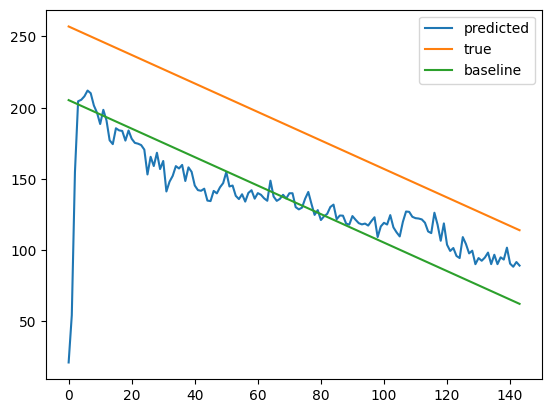

In [117]:
k = 50
plt.plot(pred_fail[k,:],label='predicted')
plt.plot(all_y[k],label='true')
plt.plot(base_pred[k],label='baseline')
plt.legend()

To get a measure of perfomance, we compute the RMSE:

In [118]:
def RMSE(pred_fail, all_y):
    return np.sqrt((pred_fail-all_y)**2)

In [119]:
res= RMSE(pred_fail,all_y)
res_base = RMSE(base_pred,all_y)

The RMSE error is the distance between the esimation and the true line above. It is constant for the baseline and should decrease as we get more and more data with our model. Here is an example on the particular exmaple above:

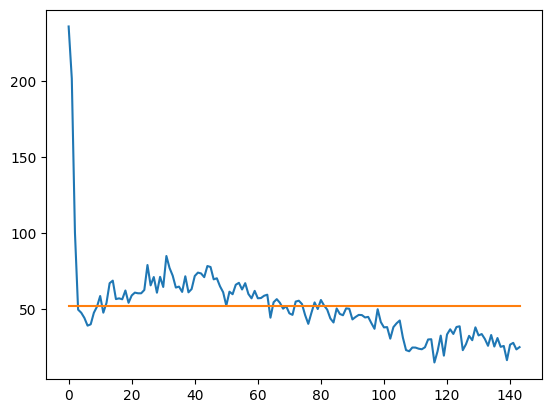

In [120]:
plt.plot(res[k])
plt.plot(res_base[k])

Below, I am averaging the RMSE over the dataset keeping the time axis (note that each point is an average but not with the same number of samples).

We see that the RMSE of the baseline is very bad for long sequences. This should be expected as these long sequences corresponds to healthy engines!

To the contrary, our model get a decreasing RMSE as a function of the length of the input sequence.

![](https://raw.githubusercontent.com/mlelarge/dataflowr/master/PlutonAI/img/rmse.png)

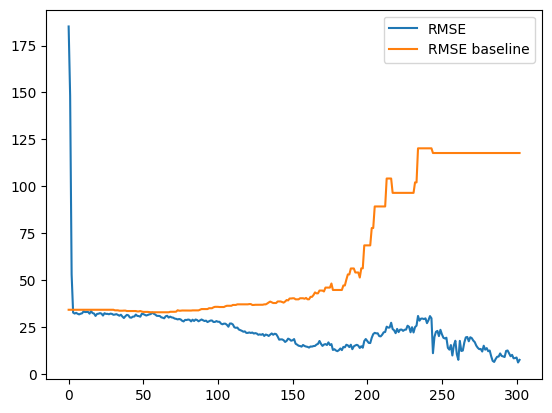

In [121]:
plt.plot(np.nanmean(res,0), label = 'RMSE')
plt.plot(np.nanmean(res_base,0), label ='RMSE baseline')
plt.legend()

In [122]:
np.nanmean(res)

np.float64(29.771789554737065)

In [123]:
np.nanmean(res_base)

np.float64(36.534097434331095)

In [124]:
last_indices = list((~np.isnan(res)).sum(axis = 1) - 1)

In [125]:
np.mean([res[i,j] for i,j in enumerate(last_indices)])

np.float64(14.836212896961065)

In [126]:
np.mean([res_base[i,j] for i,j in enumerate(last_indices)])

np.float64(34.1034)

Above we see that we divided the RMSE by more than 2 compare to the baseline.

Here we do a scatter plot of the predictions vs true values for the baseline method (closer to the diagonal in blue is better):

![](https://raw.githubusercontent.com/mlelarge/dataflowr/master/PlutonAI/img/base_scatter.png)

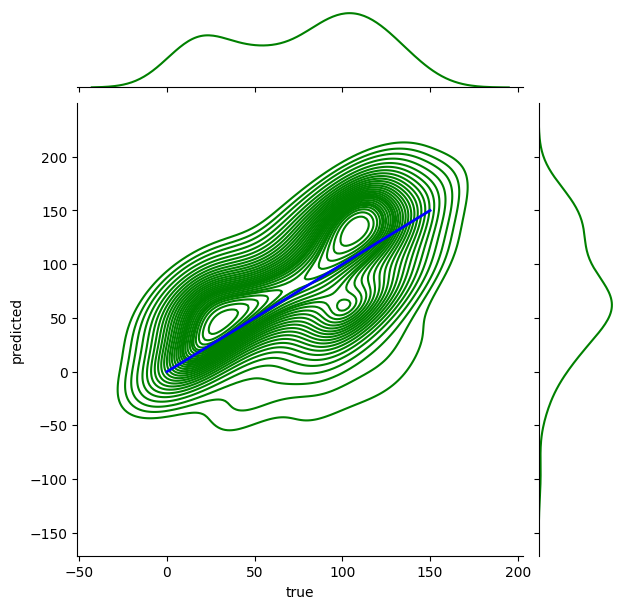

In [127]:
plot = sns.jointplot(x=[all_y[i,j] for i,j in enumerate(last_indices)],y=[base_pred[i,j] for i,j in enumerate(last_indices)],dropna=True,kind="kde", n_levels=30, color="g");
plot.ax_joint.plot([0,150], [0,150], 'b-', linewidth = 2);
plot.set_axis_labels('true', 'predicted');

Now we do the same scatter plot with our model (colser to the diagonal in blue is better). We see a great improvement.

![](https://raw.githubusercontent.com/mlelarge/dataflowr/master/PlutonAI/img/model_scatter.png)

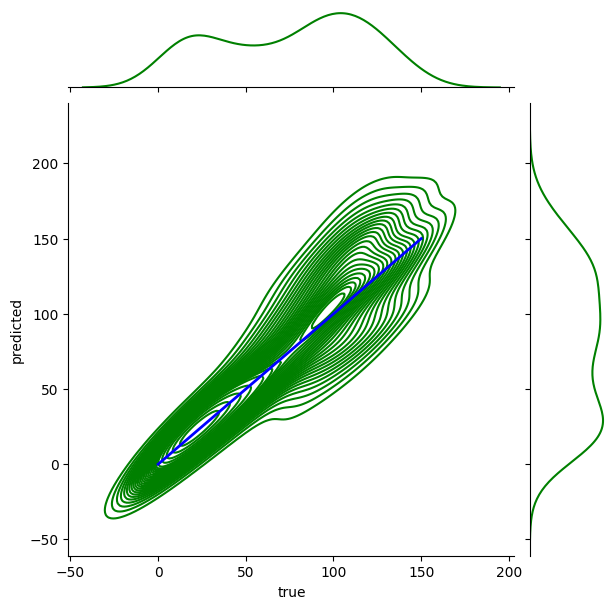

In [128]:
plot = sns.jointplot(x=[all_y[i,j] for i,j in enumerate(last_indices)],y=[pred_fail[i,j] for i,j in enumerate(last_indices)],dropna=True,kind="kde", n_levels=30, color="g");
plot.ax_joint.plot([0,150], [0,150], 'b-', linewidth = 2);
plot.set_axis_labels('true', 'predicted');